In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
from csv import writer
import math
import cmath
import pickle

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential,load_model
from keras.layers import Input, Embedding
from keras.layers import Dense, Bidirectional
from keras.layers.recurrent import LSTM
import keras.metrics as metrics
import itertools
from tensorflow.python.keras.utils.data_utils import Sequence
from decimal import Decimal
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense

In [3]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16])
    out= pd.read_csv('data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19])
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)

[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


In [5]:
from sklearn.preprocessing import MinMaxScaler
import warnings
scaler_obj=MinMaxScaler()
X1=scaler_obj.fit_transform(A1)
Y1=scaler_obj.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)

X1=X1[:,np.newaxis,:]
Y1=Y1[:,np.newaxis,:]

In [6]:
from keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [7]:
model = Sequential()
model.add(keras.Input(shape=(1,5)))
model.add(tf.keras.layers.GRU(14,activation="relu",use_bias=True,kernel_initializer="glorot_uniform",bias_initializer="zeros", 
                                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                bias_regularizer=keras.regularizers.l2(1e-4),
                                activity_regularizer=keras.regularizers.l2(1e-5)))
model.add(keras.layers.Dropout(.1))
model.add(Dense(7))
model.add(keras.layers.BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,
                                beta_initializer="zeros",gamma_initializer="ones",
                                moving_mean_initializer="zeros",moving_variance_initializer="ones",trainable=True))
model.add(keras.layers.ReLU())
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 14)                882       
_________________________________________________________________
dropout_1 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 105       
_________________________________________________________________
batch_normalization_1 (Batch (None, 7)                 28        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7)                 0         
Total params: 1,015
Trainable params: 1,001
Non-trainable params: 14
_________________________________________________________________


In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

history2 = model.fit(x_train,y_train,batch_size=2048,epochs=300, validation_split=0.1)

Epoch 1/300
571/571 [==============================] - 124s 217ms/step - loss: 1.6267e-04 - accuracy: 0.9438 - val_loss: 1.6265e-04 - val_accuracy: 0.9439
Epoch 2/300
571/571 [==============================] - 207s 364ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6256e-04 - val_accuracy: 0.9439
Epoch 3/300
571/571 [==============================] - 216s 378ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6253e-04 - val_accuracy: 0.9439
Epoch 4/300
571/571 [==============================] - 217s 380ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6262e-04 - val_accuracy: 0.9439
Epoch 5/300
571/571 [==============================] - 217s 379ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6261e-04 - val_accuracy: 0.9439
Epoch 6/300
571/571 [==============================] - 215s 377ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6250e-04 - val_accuracy: 0.9439
Epoch 7/300
571/571 [==============================] - 215s 377ms/step

571/571 [==============================] - 216s 378ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6268e-04 - val_accuracy: 0.9439
Epoch 54/300
571/571 [==============================] - 216s 378ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6256e-04 - val_accuracy: 0.9439
Epoch 55/300
571/571 [==============================] - 216s 378ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6251e-04 - val_accuracy: 0.9439
Epoch 56/300
571/571 [==============================] - 217s 380ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6273e-04 - val_accuracy: 0.9439
Epoch 57/300
571/571 [==============================] - 225s 395ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6264e-04 - val_accuracy: 0.9439
Epoch 58/300
571/571 [==============================] - 243s 425ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6253e-04 - val_accuracy: 0.9439
Epoch 59/300
571/571 [==============================] - 232s 407ms/step - los

571/571 [==============================] - 218s 383ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6256e-04 - val_accuracy: 0.9439
Epoch 106/300
571/571 [==============================] - 216s 378ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6280e-04 - val_accuracy: 0.9439
Epoch 107/300
571/571 [==============================] - 217s 381ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6250e-04 - val_accuracy: 0.9439
Epoch 108/300
571/571 [==============================] - 217s 379ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6251e-04 - val_accuracy: 0.9439
Epoch 109/300
571/571 [==============================] - 217s 380ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6250e-04 - val_accuracy: 0.9439
Epoch 110/300
571/571 [==============================] - 217s 381ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6251e-04 - val_accuracy: 0.9439
Epoch 111/300
571/571 [==============================] - 217s 380ms/step

571/571 [==============================] - 216s 379ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6250e-04 - val_accuracy: 0.9439
Epoch 158/300
571/571 [==============================] - 217s 380ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6277e-04 - val_accuracy: 0.9439
Epoch 159/300
571/571 [==============================] - 218s 381ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6251e-04 - val_accuracy: 0.9439
Epoch 160/300
571/571 [==============================] - 217s 380ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6250e-04 - val_accuracy: 0.9439
Epoch 161/300
571/571 [==============================] - 216s 379ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6262e-04 - val_accuracy: 0.9439
Epoch 162/300
571/571 [==============================] - 217s 380ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6252e-04 - val_accuracy: 0.9439
Epoch 163/300
571/571 [==============================] - 217s 380ms/step

571/571 [==============================] - 216s 379ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6255e-04 - val_accuracy: 0.9439
Epoch 210/300
571/571 [==============================] - 217s 379ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6252e-04 - val_accuracy: 0.9439
Epoch 211/300
571/571 [==============================] - 217s 380ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6251e-04 - val_accuracy: 0.9439
Epoch 212/300
571/571 [==============================] - 217s 381ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6259e-04 - val_accuracy: 0.9439
Epoch 213/300
571/571 [==============================] - 218s 381ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6251e-04 - val_accuracy: 0.9439
Epoch 214/300
571/571 [==============================] - 217s 381ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6289e-04 - val_accuracy: 0.9439
Epoch 215/300
571/571 [==============================] - 216s 378ms/step

571/571 [==============================] - 216s 378ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6255e-04 - val_accuracy: 0.9439
Epoch 262/300
571/571 [==============================] - 217s 380ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6280e-04 - val_accuracy: 0.9439
Epoch 263/300
571/571 [==============================] - 217s 380ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6263e-04 - val_accuracy: 0.9439
Epoch 264/300
571/571 [==============================] - 217s 380ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6265e-04 - val_accuracy: 0.9439
Epoch 265/300
571/571 [==============================] - 218s 383ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6277e-04 - val_accuracy: 0.9439
Epoch 266/300
571/571 [==============================] - 216s 379ms/step - loss: 1.6265e-04 - accuracy: 0.9438 - val_loss: 1.6307e-04 - val_accuracy: 0.9439
Epoch 267/300
571/571 [==============================] - 217s 380ms/step

In [15]:
model.evaluate(x_test,y_test)

13518/13518 [==============================] - 17s 1ms/step - loss: 1.6276e-04 - accuracy: 0.9435


[0.00016275774396490306, 0.9434838891029358]

In [16]:
model_json = model.to_json()
with open("gru.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("gru.h5")
print("Saved model to disk")

Saved model to disk


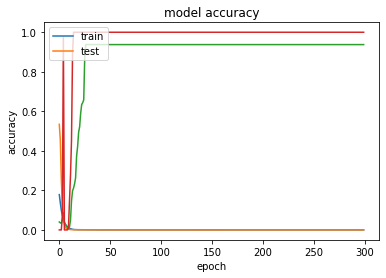

In [10]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')